(heavy_tail)=
# 厚尾分布

除了 Anaconda 中的内容外，本讲座还需要以下库：

In [1]:
!pip install --upgrade yfinance pandas_datareader interpolation


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


图像输入功能：已启用

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm

from interpolation import interp
from pandas_datareader import wb
from scipy.stats import norm, cauchy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 概述

在本节中，我们给出讲座的动机。

### 介绍：轻尾

经典统计学和自然科学中{doc}`常用的概率分布 <prob_dist>`大多具有“轻尾”。

为了解释这个概念，让我们首先看一些例子。

经典例子是[正态分布](https://en.wikipedia.org/wiki/Normal_distribution)，其密度为

$$ 
    f(x) = \frac{1}{\sqrt{2\pi}\sigma} 
    \exp\left( -\frac{(x-\mu)^2}{2 \sigma^2} \right)
    \qquad
    (-\infty < x < \infty)
$$

两个参数 $\mu$ 和 $\sigma$ 分别是均值和标准差。

当 $x$ 偏离 $\mu$ 时，$f(x)$ 的值会非常快地归零。

我们可以通过绘制密度图并显示观测值的直方图来看到这一点，如以下代码所示（假设 $\mu=0$ 和 $\sigma=1$）。

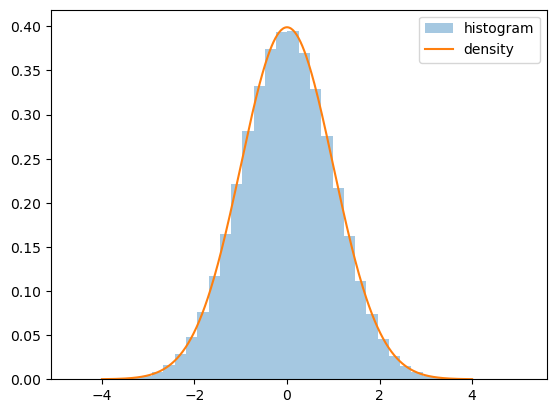

In [3]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='histogram', density=True)
x_grid = np.linspace(-4, 4, 400)
ax.plot(x_grid, norm.pdf(x_grid), label='density')
ax.legend()
plt.show()

注意到

* 密度的尾部在两个方向上快速收敛到零，并且
* 即使有 1,000,000 次抽样，我们也没有非常大或非常小的观测值。

我们可以通过执行以下代码更清楚地看到最后一点

In [4]:
X.min(), X.max()

(-4.619405853384446, 5.125214679931336)

结果表明，1,000,000 次观测值的范围远远小于 $[-10, 10]$：

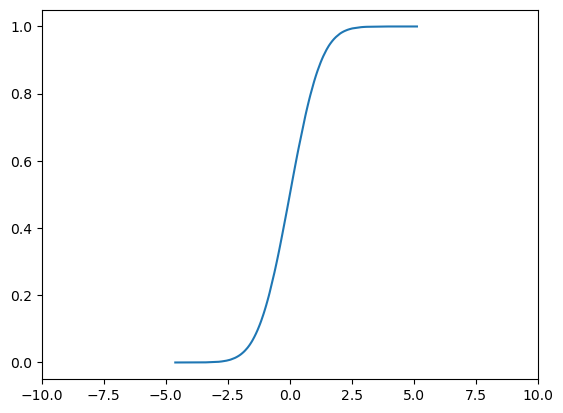

In [5]:
fig, ax = plt.subplots()
ax.plot(sorted(X), np.linspace(0, 1, len(X), endpoint=False))
ax.set_xlim(-10, 10)
plt.show()

我们已经绘制了每个单独抽样 $X_i$ 与 $i$ 的关系。

没有一个特别大或特别小。

换句话说，极端观测值很少，抽样值往往不会偏离均值太多。

换句话说，轻尾分布是指很少产生极端值的分布。

（下面给出了更正式的定义。）

许多统计学家和计量经济学家使用经验法则，比如“均值偏离四到五倍标准差以上的结果可以安全地忽略”。

但这只有在分布有轻尾时才是正确的。

### 轻尾何时有效？

在概率论和现实世界中，许多分布是轻尾的。

例如，人的身高是轻尾的。

是的，我们确实看到一些非常高的人。

* 例如，篮球运动员 [孙明明](https://zh.wikipedia.org/wiki/孙明明) 身高 2.32 米

但你曾经听说过有人身高 20 米吗？或 200 米？或 2000 米？

你是否想过为什么？

毕竟，世界上有 80 亿人口！

本质上，我们之所以看不到这种抽样值，是因为人的身高分布具有非常轻的尾部。

事实上，人的身高分布遵循类似于正态分布的钟形曲线。

### 资产的回报

但经济数据呢？

让我们先看看一些金融数据。

我们的目标是绘制从 2015 年 1 月 1 日到 2022 年 7 月 1 日期间亚马逊 (AMZN) 股票价格的日变化。

如果我们不考虑股息，这相当于每日回报。

下面的代码使用 `yfinance` 库通过雅虎金融数据生成所需的图表。

[*********************100%%**********************]  1 of 1 completed

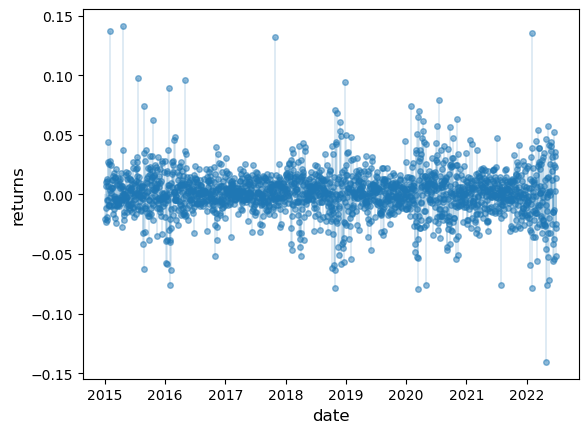

In [6]:
s = yf.download('AMZN', '2015-1-1', '2022-7-1')['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

这些数据看起来与我们上面看到的正态分布的抽样结果不同。

有几次观测值非常极端。

观察其他资产（如比特币）会得到类似的图景

[*********************100%%**********************]  1 of 1 completed

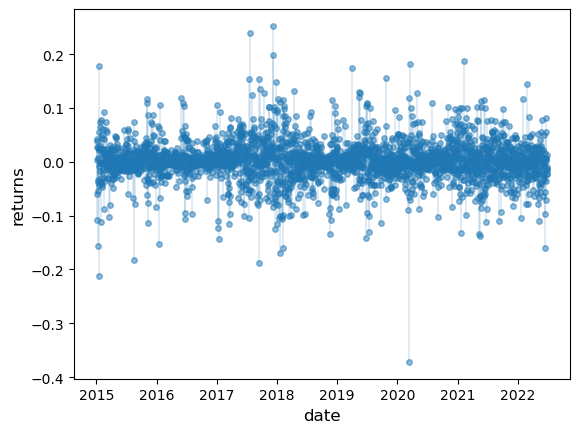

In [7]:
s = yf.download('BTC-USD', '2015-1-1', '2022-7-1')['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

从图中我们看到，比特币的日变化比亚马逊股票价格的日变化更为极端。

我们再看一张图片。

请记住，正态分布的直方图如下所示：

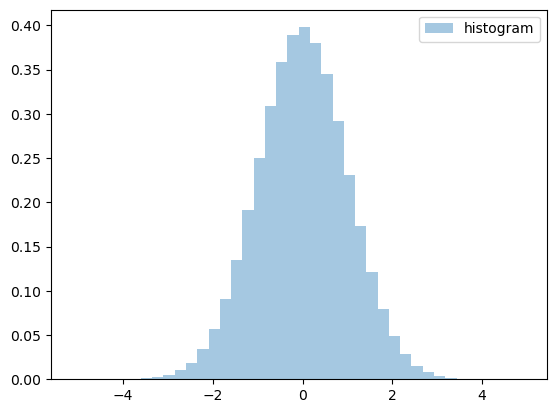

In [8]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='histogram', density=True)
ax.legend()
plt.show()

比特币回报的直方图也看起来不同于正态分布的直方图：

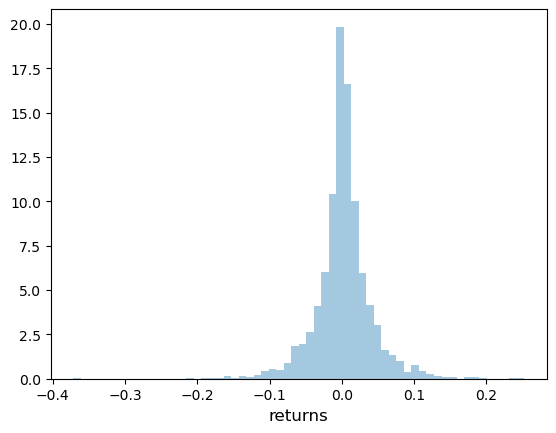

In [9]:
fig, ax = plt.subplots()
ax.hist(r, bins=60, alpha=0.4, label='bitcoin returns', density=True)
ax.set_xlabel('returns', fontsize=12)
plt.show()

### 更高频率的数据

如果我们查看高频率的回报数据（例如，逐笔），我们经常会看到更为极端的观测值。

例如，参见 {cite}`mandelbrot1963variation` 或 {cite}`rachev2003handbook`。

### 其他数据

我们刚才看到的数据被称为“厚尾”。

对于厚尾分布，极端结果相对频繁发生。

重要的是，在经济和金融环境中，观察到许多厚尾分布的例子！

例如，收入和财富分布是厚尾的

* 你可以想象这样：大多数人财富较低或适中，但有些人极其富有。

企业规模分布也是厚尾的

* 你也可以想象这样：大多数公司都很小，但有些公司非常巨大。

城镇和城市的分布也是厚尾的

* 大多数城镇和城市很小，但有些很大。

稍后在本讲座中，我们将检查这些分布中的厚尾现象。

### 我们为什么要关心？

经济数据中厚尾现象很常见，但这意味着它们重要吗？

这个问题的答案是肯定的！

当分布是厚尾时，我们需要仔细考虑一些问题，比如

* 分散和风险
* 预测
* 税收（跨越厚尾的收入分布）等。

我们将在下面回到这些点。

## 视觉比较

稍后我们将提供轻尾和厚尾之间差别的数学定义。

但现在让我们做一些视觉比较，以帮助我们直观理解这两类分布的差异。

### 模拟

下图显示了一个模拟。

前两个子图各显示从正态分布（轻尾）中独立抽样的 120 个样本。

下图显示从[柯西分布](https://zh.wikipedia.org/wiki/柯西分布)（厚尾）中独立抽样的 120 个样本。

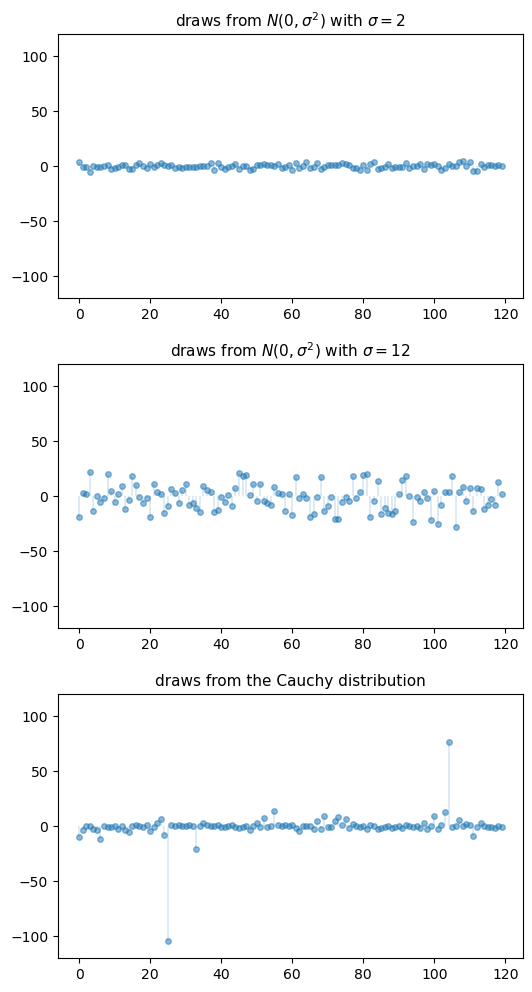

In [10]:
n =120
np.random.seed(11)

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

for ax in axes:
    ax.set_ylim((-120, 120))

s_vals = 2, 12

for ax, s in zip(axes[:2], s_vals):
    data = np.random.randn(n) * s
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"draws from $N(0, \sigma^2)$ with $\sigma = {s}$", fontsize=11)

ax = axes[2]
distribution = cauchy()
data = distribution.rvs(n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_title(f"draws from the Cauchy distribution", fontsize=11)

plt.subplots_adjust(hspace=0.25)

plt.show()

在顶部子图中，正态分布的标准差为2，并且抽样值聚集在均值周围。

在中间子图中，标准差增加到12，正如预期的那样，离散程度上升。

底部子图中，柯西分布的抽样值展示了不同的模式：大多数观测值紧密聚集在均值附近，但同时也有一些突然的大偏离。

这是厚尾分布的典型特征。


### 非负分布

让我们比较一些只取非负值的分布。

其中一个是指数分布，我们在{doc}`关于概率和分布的讲座 <prob_dist>`中讨论过。

指数分布是轻尾分布。

这里是一些从指数分布中抽样的结果。

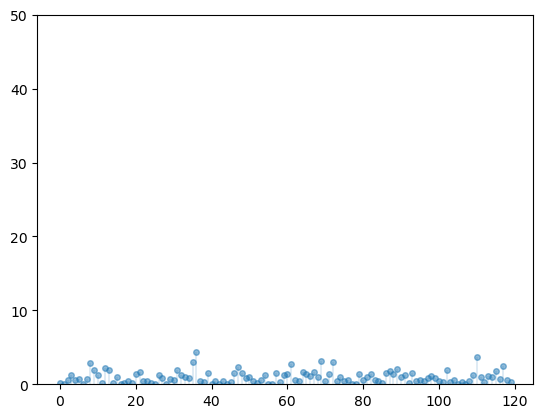

In [11]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 50))

data = np.random.exponential(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)

plt.show()

另一种非负分布是[Pareto分布](https://zh.wikipedia.org/wiki/Pareto分布)。

如果$X$具有Pareto分布，那么有正的常数$\bar x$ 和 $\alpha$ 使得

```{math}
:label: pareto

\mathbb P\{X > x\} =
\begin{cases}
    \left( \bar x/x \right)^{\alpha}
        & \text{ if } x \geq \bar x
    \\
    1
        & \text{ if } x < \bar x
\end{cases}
```

参数 $\alpha$ 被称为**尾指数**，$\bar x$ 被称为**最小值**。

Pareto分布是一种厚尾分布。

Pareto分布的一种出现方式是作为指数随机变量的指数。

特别地，如果$X$是具有速率参数$\alpha$的指数分布，那么

$$   Y = \bar x \exp(X) $$

是具有最小值 $\bar x$ 和尾指数 $\alpha$ 的Pareto分布。

以下是尾指数为1和最小值为1的Pareto分布的一些抽样。

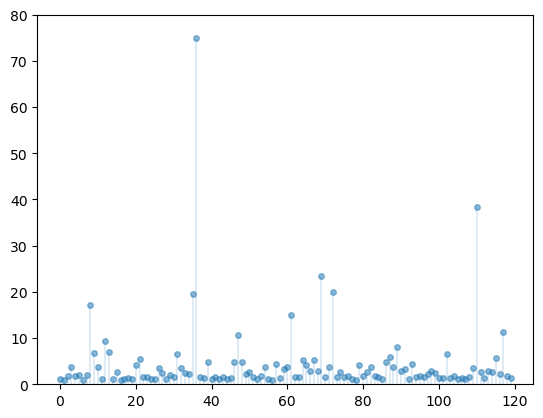

In [12]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 80))
exponential_data = np.random.exponential(size=n)
pareto_data = np.exp(exponential_data)
ax.plot(list(range(n)), pareto_data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, pareto_data, lw=0.2)

plt.show()

请注意，尽管大多数观测值接近零，但图中有相当多的观测值距离均值很远。

```{exercise}
:label: ht_ex1

下面的图中（从上到下）显示了
(i) 从正态分布抽样，
(ii) 从Pareto分布抽样，
(iii) 从正态分布抽样的平方。

* 识别(i)-(iii)中的子图。
* 解释(i)和(ii)之间以及(ii)和(iii)之间的差异。
```

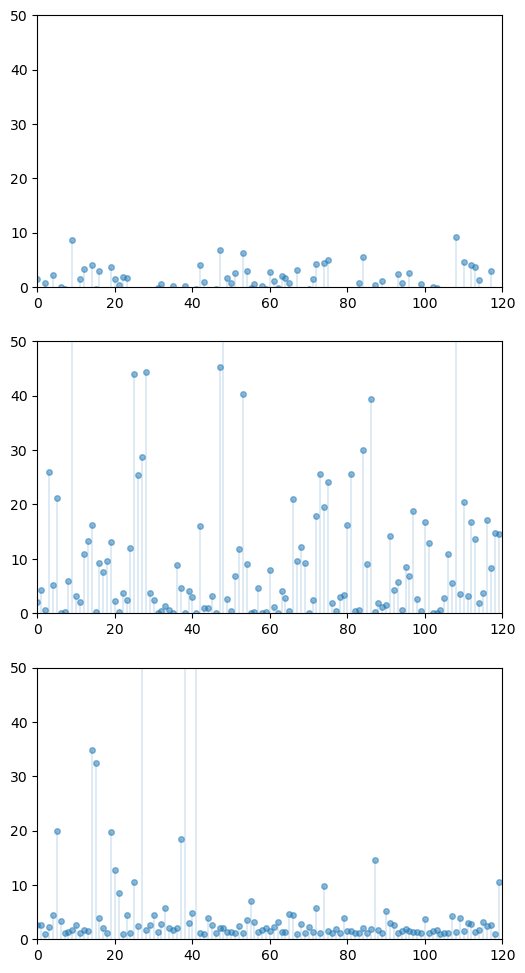

In [13]:
np.random.seed(12)

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

for ax in axes:
    ax.set_ylim((0, 50))
    ax.set_xlim((0, n))

s = 3

data = np.random.randn(n) * s
axes[0].plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
axes[0].vlines(list(range(n)), 0, data, lw=0.2)

axes[1].plot(list(range(n)), data**2, linestyle='', marker='o', alpha=0.5, ms=4)
axes[1].vlines(list(range(n)), 0, data**2, lw=0.2)

exponential_data = np.random.exponential(size=n)
pareto_data = np.exp(exponential_data)
axes[2].plot(list(range(n)), pareto_data, linestyle='', marker='o', alpha=0.5, ms=4)
axes[2].vlines(list(range(n)), 0, pareto_data, lw=0.2)

plt.show()

提示：这里是{doc}`关于厚尾分布的讲座 <prob_dist>`中正态分布密度函数和其抽样观测值的图。

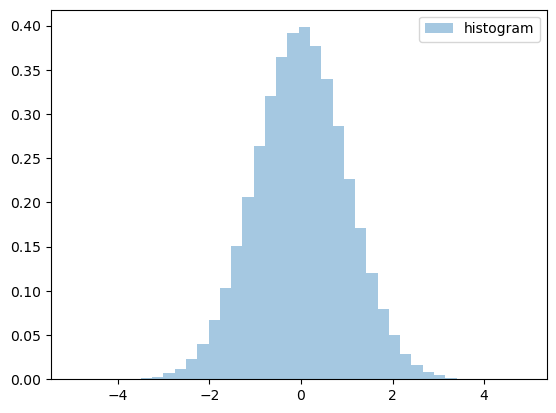

In [14]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='histogram', density=True)
ax.legend()
plt.show()

### 长期行为

厚尾和轻尾分布的另一个直观比较是看它们长期行为。

正态和柯西分布的99个样本的平均值和标准差如下所示。

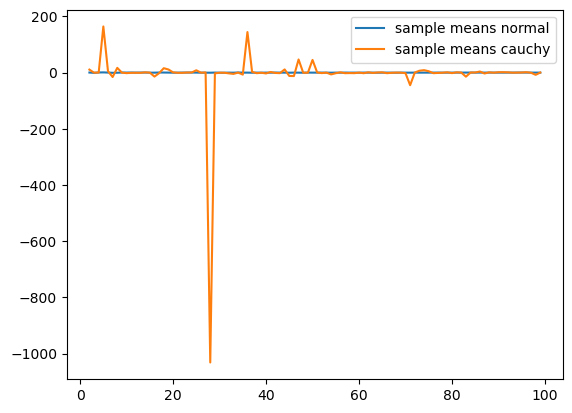

In [15]:
n = 99
distribution1 = norm()
distribution2 = cauchy()

replications = range(2, n + 1)
means1 = [distribution1.rvs(k).mean() for k in replications]
means2 = [distribution2.rvs(k).mean() for k in replications]

fig, ax = plt.subplots()
ax.plot(replications, means1, label='sample means normal')
ax.plot(replications, means2, label='sample means cauchy')

ax.legend()
plt.show()

请注意：

- 样本平均值收敛到其理论均值 $\mu =0$ （正态）。
- 样本平均值不收敛（柯西）。

最后，一些厚尾和轻尾分布的尾部比较使用对数图绘制显示如下。

NameError: name 'x' is not defined

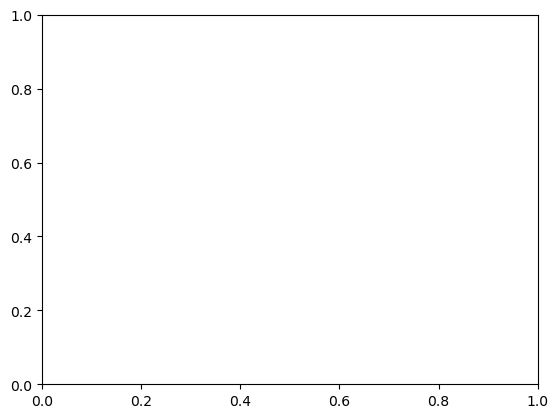

In [16]:
fig, ax = plt.subplots()
alpha = 1.0
ax.plot(x, np.exp(- alpha * x), label='exponential', alpha=0.8)
ax.plot(x, x**(- alpha), label="Pareto", alpha=0.8)
ax.legend()
plt.show()

这种比较很难在上图中进行，因此请查看对数图

In [ ]:
fig, ax = plt.subplots()
alpha = 1.0
ax.loglog(x, np.exp(- alpha * x), label='exponential', alpha=0.8)
ax.loglog(x, x**(- alpha), label='Pareto', alpha=0.8)
ax.legend()
plt.show()

## 更正式的定义

我们现在尝试将这些区别概念化。

一种方法是定义累积分布函数（CDF）。

- 给定$r \in \mathbb{R}$，CDF $F$在$r$上的值是$F(r) = \mathbb{P}(R \leq r)$。
- 换句话说，它等于$R$小于等于$r$的概率。

尾层函数通过将权重（概率）集中分布在每个尾部来计算（1-CDF）。

> 注意：尾行为定义为CDF。

厚尾行为与异常行为相关。

回想一下，正态分布的密度函数对应以下RAND MATLAB代码实现随机数的分布。

In [ ]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='histogram', density=True)
ax.plot(x, norm.pdf(x), label='density')
ax.legend()
plt.show()

由此，我们可以看到，随机提供截尾权重（尾部）通常是不可接受的。

在对数对数图中，Pareto CCDF 是线性的，而指数 CCDF 是凹的。

这个思路通常用于在可视化中区分轻尾和重尾分布——我们将在下文中回到这一点。


### 经验 CCDFs

CCDF 函数的样本对应物是**经验 CCDF**。

给定样本 $x_1, \ldots, x_n$，经验 CCDF 表示为

$$ \hat G(x) = \frac{1}{n} \sum_{i=1}^n \mathbb 1\{x_i > x\} $$

因此，$\hat G(x)$ 显示样本中超过 $x$ 的部分。

下图展示了模拟数据的一些经验 CCDF。

In [ ]:
def eccdf(x, data):
    "Simple empirical CCDF function."
    return np.mean(data > x)

x_grid = np.linspace(1, 1000, 1000)
sample_size = 1000
np.random.seed(13)
z = np.random.randn(sample_size)

data_1 = np.random.exponential(size=sample_size)
data_2 = np.exp(z)
data_3 = np.exp(np.random.exponential(size=sample_size))

data_list = [data_1, data_2, data_3]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes = axes.flatten()
labels = ['exponential', 'lognormal', 'Pareto']

for data, label, ax in zip(data_list, labels, axes):

    ax.loglog(x_grid, [eccdf(x, data) for x in x_grid], 
        'o', markersize=3.0, alpha=0.5, label=label)
    ax.set_xlabel("log value")
    ax.set_ylabel("log prob")
    
    ax.legend()
    
    
fig.subplots_adjust(hspace=0.4)

plt.show()

如上图所示：

- 对数正态和 Pareto 分布显现出近似线性尾行为，对应重尾分布的特征。
- 指数分布的尾行为明显凹入，对应轻尾分布的特征。

使用变量 $X \sim \text{Pareto}(\alpha)$，我们有 $\mathbb P\{X > x\} = (\bar x/x)^\alpha$。

如 CCDF 所示，Pareto 分布在对数对数图中显示出线性特性。

从 Pareto 分布中得出的经验 CCDF 在对数对数图中也是近似线性的。

我们将在下面处理真实数据时使用这一想法。

### 幂律分布


一种特定类型的重尾分布在经济和社会现象中反复出现：这就是所谓的幂律分布。

若随机变量 $X$ 满足某个 $\alpha > 0$，则称其具有**幂律分布**，如果

```{math}
\mathbb P\{X > x\} \approx  x^{-\alpha}
\quad \text{当 $x$ 较大时}
```

我们可以更数学化地表示为

```{math}
:label: plrt

\lim_{x \to \infty} x^\alpha \, \mathbb P\{X > x\} = c
\quad \text{对于某些 $c > 0$}
```

具有该属性的随机变量 $X$ 也被称为具有**尾指数** $\alpha$ 的**Pareto 尾部**。

注意，每个具有尾指数 $\alpha$ 的 Pareto 分布也有一个具有相同尾指数的**Pareto 尾**。

我们可以将幂律分布视为 Pareto 分布的泛化。

它们在其右上尾部与 Pareto 分布相似。

另一种理解幂律分布的方法是一组具有特定类型（非常）重尾的分布。

## 经济横截面上的重尾现象

如上所述，经济数据中普遍存在重尾现象。

实际上，幂律分布似乎也很常见。

我们现在通过展示重尾现象的经验 CCDF 来说明这一点。

所有图表采用对数对数坐标，因此幂律分布在对数对数图上至少在上尾部分呈线性。

我们隐藏生成图形的代码（相对复杂），但读者当然可以探索代码（也许在查看图形后）。

In [ ]:
def empirical_ccdf(data, 
                   ax, 
                   aw=None,   # weights
                   label=None,
                   xlabel=None,
                   add_reg_line=False, 
                   title=None):
    """
    Take data vector and return prob values for plotting.
    Upgraded empirical_ccdf
    """
    y_vals = np.empty_like(data, dtype='float64')
    p_vals = np.empty_like(data, dtype='float64')
    n = len(data)
    if aw is None:
        for i, d in enumerate(data):
            # record fraction of sample above d
            y_vals[i] = np.sum(data >= d) / n
            p_vals[i] = np.sum(data == d) / n
    else:
        fw = np.empty_like(aw, dtype='float64')
        for i, a in enumerate(aw):
            fw[i] = a / np.sum(aw)
        pdf = lambda x: interp(data, fw, x)
        data = np.sort(data)
        j = 0
        for i, d in enumerate(data):
            j += pdf(d)
            y_vals[i] = 1- j

    x, y = np.log(data), np.log(y_vals)
    
    results = sm.OLS(y, sm.add_constant(x)).fit()
    b, a = results.params
    
    kwargs = [('alpha', 0.3)]
    if label:
        kwargs.append(('label', label))
    kwargs = dict(kwargs)

    ax.scatter(x, y, **kwargs)
    if add_reg_line:
        ax.plot(x, x * a + b, 'k-', alpha=0.6, label=f"slope = ${a: 1.2f}$")
    if not xlabel:
        xlabel='log value'
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("log prob", fontsize=12)
        
    if label:
        ax.legend(loc='lower left', fontsize=12)
        
    if title:
        ax.set_title(title)
        
    return np.log(data), y_vals, p_vals

```

```{code-cell} ipython3
# Plot the empirical CDFs

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(draws1, bins=40, alpha=0.4, label='Normal', density=True)
ax.hist(draws2, bins=40, alpha=0.4, label='Cauchy', density=True)

ax.legend()

plt.show()
```
如上图所示，极端观测值在厚尾分布（柯西分布）的情况下更频繁地出现。

当然，对于较大的数据量，这种情况会变得更加明显。

优秀的统计程序可以对各类分布进行建模并进行风险评估。

```{note}
需要注意的是，风险评估的一个实际问题是如何权衡方差与极端风险。这在经济学和金融中的应用广泛，也是研究的重要议题。
```

### 回看我们的企业数据

我们在上文中使用的公司的数据表明，收入、财富和城市规模都展示了厚尾特性。

为了更好地理解这种性质对风险的影响，现在我们将回顾公司数据并分析其中的风险因素。我们将生成公司的收入和企业规模的数据，并展示它们的厚尾性质。

```{note}
在实际应用中，建模厚尾风险需要多种技术，比如极值理论和贝叶斯统计。
```

## 小结

* 许多经济现象表现出重尾特性，其中较大部分的数据点有时会在右尾出现，形成与正态分布不同的厚尾。
* 进行预测和风险评估时，了解并考虑到数据的厚尾性质非常重要。
* 极端值出现频率较高时（如在金融市场中的情况），传统的统计方法（例如基于正态分布的假设）可能不再适用，需要采用更适合的厚尾分布模型。

对于希望进一步理解的读者，我们建议研究极值理论和贝叶斯统计，特别是它们在建模和预测厚尾分布中的应用。

In [ ]:
# import population data of cities in 2023 United States and 2023 Brazil from world population review
df_cs_us = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_us.csv')
df_cs_br = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_brazil.csv')

fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

empirical_ccdf(np.asarray(df_cs_us["pop2023"]), axes[0], label="US", add_reg_line=True)
empirical_ccdf(np.asarray(df_cs_br['pop2023']), axes[1], label="Brazil", add_reg_line=True)

plt.show()

### 财富

这里是财富分布上尾部（前 500 名）的图示。

数据来自福布斯 2020 年亿万富翁榜单。

In [ ]:
df_w = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/forbes-billionaires.csv')
df_w = df_w[['country', 'realTimeWorth', 'realTimeRank']].dropna()
df_w = df_w.astype({'realTimeRank': int})
df_w = df_w.sort_values('realTimeRank', ascending=True).copy()
countries = ['United States', 'Japan', 'India', 'Italy']  
N = len(countries)

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

for i, c in enumerate(countries):
    df_w_c = df_w[df_w['country'] == c].reset_index()
    z = np.asarray(df_w_c['realTimeWorth'])
    # print('number of the global richest 2000 from '+ c, len(z))
    top = 500           # cut-off number: top 500
    if len(z) <= top:    
        z = z[:top]

    empirical_ccdf(z[:top], axs[i], label=c, xlabel='log wealth', add_reg_line=True)
    
fig.tight_layout()

plt.show()

### 人口

以下展示了 2023 年至 2027 年全球某些国家的人口分布。

数据源自[联合国世界城市人口数据集](https://population.un.org/wpp/)。

In [ ]:
df_p1 = pd.read_csv('https://python-programming.quantecon.org/un_population.csv')
df_p1 = df_p1[(df_p1["Year"] == 2023)]
countries = ['United States', 'Japan', 'India', 'Italy']  
N = len(countries)

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

for i, c in enumerate(countries):
    df_p1_c = df_p1[df_p1['Location'] == c].reset_index()
    z = np.asarray(df_p1_c['Population'])
    # print('population of '+ c, len(z))

    empirical_ccdf(z, axs[i], label=c, xlabel='log population', add_reg_line=True)
    
fig.tight_layout()

plt.show()

## 拓展阅读

1. **极值理论和风险**: 极值理论提供了对极端事件的概率性质的建模方法。在金融和保险中，这些方法可以用来估计罕见事件（如市场崩盘或自然灾害）的风险。

2. **贝叶斯统计**: 贝叶斯统计提供了一种处理不确定性的方法，尤其适用于重尾分布。贝叶斯方法不仅能够处理复杂的分布，还能结合先验知识，使预测更加准确。

3. **齐普夫定律**: 齐普夫定律是一种特殊的幂律分布，广泛应用于语言学、城市规模分布和企业规模分布。如果您对城市规模和企业规模的分布感兴趣，齐普夫定律是一个重要的模型。

4. **金融市场中的重尾现象**: 由于金融市场经常表现出重尾特性，包括“黑天鹅”事件，对风险管理尤为重要。研究表明，正态分布不足以捕捉这些极端事件，需要采用更复杂的重尾分布模型进行建模和风险评估。

这些领域的相关文献和研究对于深入理解重尾现象及其在经济和金融中的应用非常有益。如果您希望进一步探索，可以查阅专门的教科书和学术论文。

## 参考文献

* Gabaix, X., 1999. **Zipf's Law for Cities: An Explanation**. Quarterly Journal of Economics.
* Mandelbrot, B. (1963). **The Variation of Certain Speculative Prices**. The Journal of Business, 36(4), 394-419.
* Rachev, S. T., Mittnik, S., Fabozzi, F. J., Focardi, S. M., & JASIC, T. (2007). **Financial econometrics: From basics to advanced modeling techniques**. John Wiley & Sons.

这些文献为重尾分布及其在经济学和金融学中的应用提供了广泛的理论和实证分析。同时，通过这些参考文献，您可以更深入地理解重尾分布的数学特性以及其在实际中的重要性。

该序列没有收敛的迹象。

在练习中我们会回到这一点。

## 为什么厚尾分布重要?

我们已经看到

1. 厚尾分布在经济学中很常见,
2. 当尾部非常厚时，大数法则失效。

但这在现实世界中又意味着什么呢？ 厚尾分布重要吗?

让我们简要讨论一下它们的重要性。

### 分散化

投资中最重要的理念之一是通过分散投资来降低风险。

这是一个非常古老的理念——例如，考虑表达“不要把所有鸡蛋放在一个篮子里”。

为了说明这一点，假设一个投资者拥有一美元财富，可以选择多个资产 $n$，它们的回报分别为 $X_1, \ldots, X_n$。  

假设不同资产的回报是独立的，并且每个回报都有均值 $\mu$ 和方差 $\sigma^2$。

如果投资者将所有财富投入一个资产中，例如，投资组合的期望回报是 $\mu$，方差是 $\sigma^2$。  

如果投资者将财富的 $1/n$ 投入每个资产中，那么投资组合的回报是

$$ Y_n = \sum_{i=1}^n \frac{X_i}{n} = \frac{1}{n} \sum_{i=1}^n X_i. $$  

尝试计算均值和方差。

你会发现

* 均值保持不变为 $\mu$，
* 投资组合的方差降低到 $\sigma^2 / n$。

正如预期的那样，分散投资降低了风险。

但这里有一个隐藏的假设：回报的方差是有限的。

如果分布是厚尾的并且方差是无限的，那么这个逻辑就是错误的。

例如，我们上面看到，如果每个 $X_i$ 都是柯西分布，那么 $Y_n$ 也是柯西分布。

这意味着分散投资根本没有帮助！

### 财政政策

财富分布尾部的厚度关系到税收和再分配政策。

收入分布也是如此。

例如，收入分布尾部的厚度有助于确定 {doc}`特定税收政策将产生多少收入 <mle>`。

(cltail)=
## 分类尾特性

到目前为止，我们讨论了轻尾和厚尾没有任何数学定义。

我们现在纠正这一点。

我们将集中注意在非负随机变量及其分布的右尾部分。

左尾部分的定义非常相似，为了简化说明我们不予讨论。

### 轻尾和厚尾

如果一个分布 $F$ 在 $\mathbb R_+$ 上具有密度 $f$，则称其为**厚尾**，如果

```{math}
:label: defht

\int_0^\infty \exp(tx) f(x) dx = \infty \; \text{ 对所有 } t > 0.
```

我们称非负随机变量 $X$ 为**厚尾**，如果其密度是厚尾的。

这等价于说它的**矩生成函数** $m(t) := \mathbb E \exp(t X)$ 对所有 $t > 0$ 是无限的。

例如，[对数正态分布](https://en.wikipedia.org/wiki/Log-normal_distribution)是厚尾的，因为它的矩生成函数在 $(0, \infty)$ 上任何位置都是无限的。

帕累托分布也是厚尾的。

```

一个分布 $F$ 在 $\mathbb R_+$ 上叫做**轻尾**，如果它不是厚尾的。

一个非负随机变量 $X$ 是**轻尾**的，如果它的分布 $F$ 是轻尾的。

例如，每个具有有界支持的随机变量都是轻尾的。（为什么？）

另外一个例子，如果 $X$ 具有[指数分布](https://en.wikipedia.org/wiki/Exponential_distribution)，其 cdf 为 $F(x) = 1 - \exp(-\lambda x)$ 对某个 $\lambda > 0$，那么它的矩生成函数是

$$ m(t) = \frac{\lambda}{\lambda - t} \quad \text{当 } t < \lambda $$

特别地，$m(t)$ 在 $t < \lambda$ 时是有限的，因此 $X$ 是轻尾的。

可以证明，如果 $X$ 是轻尾的，那么它的所有[矩](https://en.wikipedia.org/wiki/Moment_(mathematics))都是有限的。

反之，如果某些矩是无限的，那么 $X$ 是厚尾的。

然而，后一个条件不是必要的。

例如，对数正态分布是厚尾的，但每个矩都是有限的。

## 拓展阅读

关于财富分布中的厚尾现象，参见例如 {cite}`pareto1896cours` 和 {cite}`benhabib2018skewed`。

关于公司规模分布中的厚尾现象，参见例如 {cite}`axtell2001zipf`，{cite}`gabaix2016power`。

关于城市规模分布中的厚尾现象，参见例如 {cite}`rozenfeld2011area`，{cite}`gabaix2016power`。

除了上述内容外，厚尾现象还有其他重要的影响。

例如，收入和财富的厚尾影响生产力增长、商业周期和政治经济学。

要进一步阅读，请参见例如 {cite}`acemoglu2002political`，{cite}`glaeser2003injustice`，{cite}`bhandari2018inequality` 或 {cite}`ahn2018inequality`。

## 练习

```{exercise}
:label: ht_ex2

证明：如果 $X$ 具有尾指数为 $\alpha$ 的帕累托尾部，那么对所有 $r \geq \alpha$，$\mathbb E[X^r] = \infty$。
```

```{solution-start} ht_ex2
:class: dropdown
```

设 $X$ 具有尾指数为 $\alpha$ 的帕累托尾，设 $F$ 为其 cdf。

固定 $r \geq \alpha$。

根据 {eq}`plrt`，我们可以取正的常数 $b$ 和 $\bar x$ 使得

$$
\mathbb P\{X > x\} \geq b x^{- \alpha} \text{ 当 } x \geq \bar x
$$

但

$$
    \mathbb E X^r = r \int_0^\infty x^{r-1} \mathbb P\{ X > x \} dx
\geq
r \int_0^{\bar x} x^{r-1} \mathbb P\{ X > x \} dx
+ r \int_{\bar x}^\infty  x^{r-1} b x^{-\alpha} dx.
$$

我们知道 $\int_{\bar x}^\infty x^{r-\alpha-1} dx = \infty$ 当 $r - \alpha - 1 \geq -1$。

由于 $r \geq \alpha$，我们有 $\mathbb E X^r = \infty$。

```{solution-end}
```

```{exercise}
:label: ht_ex3

重复练习1，但将三个分布（两个正态，一个柯西）替换为三个帕累托分布，使用不同的 $\alpha$ 选择。

对于 $\alpha$，尝试 1.15，1.5 和 1.75。

使用 `np.random.seed(11)` 设置种子。
```

```{solution-start} ht_ex3
:class: dropdown
```

In [ ]:
from scipy.stats import pareto

np.random.seed(11)

n = 120
alphas = [1.15, 1.50, 1.75]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))

for (a, ax) in zip(alphas, axes):
    ax.set_ylim((-5, 50))
    data = pareto.rvs(size=n, scale=1, b=a)
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"帕累托抽样，$\\alpha = {a}$", fontsize=11)

plt.subplots_adjust(hspace=0.4)

plt.show()

```{solution-end}
```

```{exercise}
:label: ht_ex4

假设数据 $X_1, \ldots, X_n$ 是独立同分布的帕累托分布，满足 {eq}`pareto`，其中 $\bar x = 1$。

1. 给出估计尾指数 $\alpha$ 的方法。
2. 使用你的估计方法，重新分析《财富》500 强公司数据。你获得的 $\alpha$ 值是多少？这对你如何看待排名前五名财富公司的数据有何帮助？

提示：使用极大似然估计。
```

```{solution-start} ht_ex4
:class: dropdown
```

1. 极大似然估计（MLE）

如果数据 $X_1, \ldots, X_n$ 是独立同分布的，满足 {eq}`pareto` 并且 $\bar x = 1$，那么 $\alpha$ 的 MLE 形式为

$$
\hat{\alpha} = \frac{n}{\sum_{i=1}^n \log(X_i)}
$$

如果你使用这个估计，我们可以对 $\alpha$ 进行计算。

2. 我们现在使用此估计方法来重新分析《财富》500 强公司的数据。

In [ ]:
from numpy import log

df_fortune = pd.read_csv('https://python-programming.quantecon.org/fortune500.csv')

# Extract data for 2010
revenues = df_fortune[df_fortune["Year"]==2010]["Revenues ($M)"]

# Apply MLE to estimate alpha
alpha_hat = len(revenues) / sum(log(revenues))
alpha_hat

我们发现，对于《财富》500 强公司数据，估计的 $\alpha$ 约为1.4（具体数值会根据编译时间略有不同）。这比 2 小，表明分布非常厚尾。因此，排名前五名财富公司的收入极端值对整体分析有显著影响。在分析政策和风险管理时需要考虑这一点。
```{solution-end}
```

```{exercise}
:label: ht_ex5

关于公司规模分布的争论仍在进行中，主要观点有认为公司规模可以被建模为帕累托分布或对数正态分布（参见例如 {cite}`fujiwara2004pareto`, {cite}`kondo2018us` 或 {cite}`schluter2019size`）。

这个议题看似较为抽象，实际上对多种经济现象有着深远影响。

为简化说明，请考虑一个拥有 100,000 家企业的经济体，设定利率 `r = 0.05` 和公司税率为 15%。

你的任务是估算未来 10 年企业税收归现值（present discounted value）。

为了进行预测，我们需要建立模型。

我们假设

1. 企业数量和企业规模分布（以利润衡量）保持不变，且
2. 企业规模分布为对数正态或帕累托分布。

估算税收归现值的方法是

1. 生成公司利润的 100,000 次抽样，
1. 乘以税率, 并且
1. 对结果进行折现求现值。

帕累托分布取形式 {eq}`pareto`，其中 $\bar x = 1$，$\alpha = 1.05$。

（根据数据，尾指数 $\alpha$ 的值通常为适用的，如 {cite}`gabaix2016power`。）

为了使对数正态分布与帕累托分布尽量相似，请选择对数正态分布参数使其均值和中位数与帕累托分布一致。

注意：对于每种分布，税收估值将是随机的，因为它基于有限数量的抽样进行估算。

为考虑这一点，为每个分布进行 100 次重复实验，并比较两个样本：

* 使用[小提琴图](https://en.wikipedia.org/wiki/Violin_plot)进行可视化并列展示，
* 打印两个样本的均值和标准差。

请使用 `np.random.seed(1234)`。

你观察到什么差异？

（注：更好的方法是建模公司动态，跟踪个别公司。我们将在后续课程中讨论这一点。）
```

```{solution-start} ht_ex5
:class: dropdown
```

为了完成练习，我们需要选择对数正态分布的参数 $\mu$ 和 $\sigma$ 使得其均值和中位数与帕累托分布相同。

这里，我们将理解为随机变量 $\exp(\mu + \sigma Z)$ 的对数正态分布，其中 $Z$ 是标准正态分布。

均值和中位数为

```{math}
\text{mean } = \frac{\alpha}{\alpha - 1}
\quad \text{and} \quad
\text{median } = 2^{1/\alpha}
```

对数正态分布对应的表达式为：

```{math}  
\frac{\alpha}{\alpha - 1} = \exp(\mu + \sigma^2/2)
\quad \text{and} \quad
2^{1/\alpha} = \exp(\mu)
```

我们解这两个方程，得到 $\mu$ 和 $\sigma$：

In [ ]:
alpha = 1.05

mean = alpha / (alpha - 1)
median = 2**(1 / alpha)

mu = np.log(median)
sigma = np.sqrt(2 * (np.log(mean) - mu))

(mu, sigma)

很好的，我们有了 $\mu$ 和 $\sigma$。现在我们将生成企业利润的随机数。

In [ ]:
# Set parameters
r = 0.05
tax = 0.15
n = 100_000
T = 10
discount_factors = [(1/(1 + r))**t for t in range(1, T + 1)]

np.random.seed(1234)

# Generate lognormal and Pareto draws
lognormal_profits = np.random.lognormal(mu, sigma, n)
pareto_profits = (np.random.pareto(alpha - 1, size=n) + 1)

# Compute tax revenue and present value
def discounted_tax_revenue(profits):
    return tax * np.sum([np.sum(profits) * factor for factor in discount_factors])

lognormal_values = [discounted_tax_revenue(lognormal_profits) for _ in range(100)]
pareto_values = [discounted_tax_revenue(pareto_profits) for _ in range(100)]

# Violin plot
fig, ax = plt.subplots()

ax.violinplot([lognormal_values, pareto_values],
              showmeans=False, showmedians=True)
ax.set_xticks([1,2])
ax.set_xticklabels(["Lognormal", "Pareto"])
ax.set_title("Present Discounted Value of Tax Revenue")
plt.show()

# Mean and standard deviation
mean_lognormal = np.mean(lognormal_values)
std_lognormal = np.std(lognormal_values)

mean_pareto = np.mean(pareto_values)
std_pareto = np.std(pareto_values)

(mean_lognormal, std_lognormal, mean_pareto, std_pareto)

你会注意到对数正态分布的税收估值趋于更高的均值和更小的方差，而帕累托分布的税收估值更易产生极大或极小的波动。这表明，尽管两种分布的均值相似，但帕累托分布的尾部较厚，这可能给实际税收带来更大的不可预测性。
```{solution-end}
```

```{exercise}
:label: ht_ex_cauchy

[Cauchy分布](https://en.wikipedia.org/wiki/Cauchy_distribution)的特征函数是

$$
    \phi(t) = \mathbb E e^{itX} = \int e^{i t x} f(x) dx = e^{-|t|}
$$ (lln_cch)

证明从Cauchy分布独立抽样的$n$个样本$X_1, \ldots, X_n$其样本均值$\bar X_n$具有与$X_1$相同的特征函数。

（这意味着样本均值永远不会收敛。）
```

```{solution-start} ht_ex_cauchy
:class: dropdown
```

由于独立性，样本均值的特征函数变为

$$
\begin{aligned}
    \mathbb E e^{i t \bar X_n }
    & = \mathbb E \exp \left\{ i \frac{t}{n} \sum_{j=1}^n X_j \right\}
    \\
    & = \mathbb E \prod_{j=1}^n \exp \left\{ i \frac{t}{n} X_j \right\}
    \\
    & = \prod_{j=1}^n \mathbb E \exp \left\{ i \frac{t}{n} X_j \right\}
    = [\phi(t/n)]^n
\end{aligned}
$$

对 {eq}`lln_cch` 进行解释，这就是 $e^{-|t|}$。

因此，对于Cauchy分布，无论$n$值如何，样本均值本身具有相同的Cauchy分布。
```{solution-end}
```